### Predicting Good or Bad From Credit Card Approvals
Application data contains information from clients when applying for credit card. The credit card data contains information on the length of time the credit card account was opened since the initial approval as well as the status of the loan during each month. The purpose of this machine learning task is to predict whether or not a client is good or bad based on the application/ credit card data. The target variable is not given so we will need to find a method to determine good or bad.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

In [2]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_1d304de22f0c4824ad8b8f7107066adf = 'https://s3.us.cloud-object-storage.appdomain.cloud'
else:
    endpoint_1d304de22f0c4824ad8b8f7107066adf = 'https://s3.private.us.cloud-object-storage.appdomain.cloud'

client_1d304de22f0c4824ad8b8f7107066adf = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='wYon5r9buNk3Fl2u2YLLWq9F212QwhMhD13Ej4Pim0K_',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_1d304de22f0c4824ad8b8f7107066adf)

body = client_1d304de22f0c4824ad8b8f7107066adf.get_object(Bucket='creditcardapprovalprediction-donotdelete-pr-5rbi3kcyuv3vgz',Key='application_record.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

app = pd.read_csv(body)
app.head()


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [3]:

body = client_1d304de22f0c4824ad8b8f7107066adf.get_object(Bucket='creditcardapprovalprediction-donotdelete-pr-5rbi3kcyuv3vgz',Key='credit_record.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

credit = pd.read_csv(body)
credit.head()


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


**Brief Exploration of Applications / Credit**

In [4]:
app.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


# Data Visulization

Number of people working status :
Laborers                 78240
Core staff               43007
Sales staff              41098
Managers                 35487
Drivers                  26090
High skill tech staff    17289
Accountants              15985
Medicine staff           13520
Cooking staff             8076
Security staff            7993
Cleaning staff            5845
Private service staff     3456
Low-skill Laborers        2140
Secretaries               2044
Waiters/barmen staff      1665
Realty agents             1041
HR staff                   774
IT staff                   604
Name: OCCUPATION_TYPE, dtype: int64


<AxesSubplot:xlabel='OCCUPATION_TYPE', ylabel='count'>

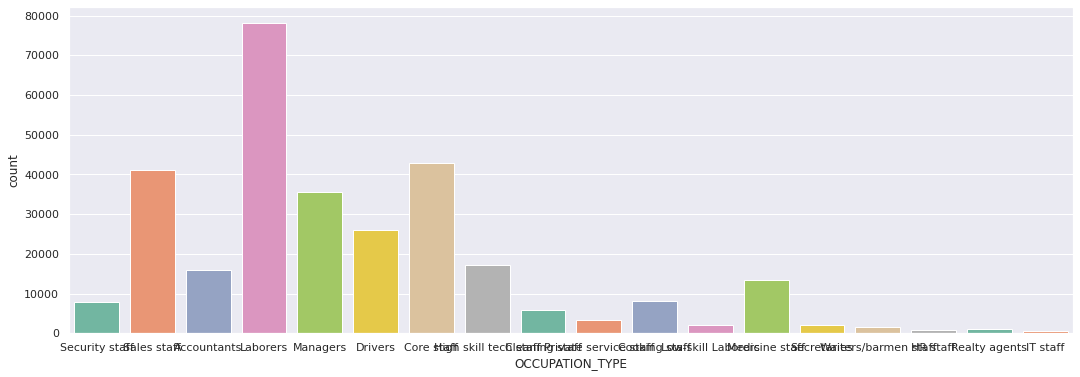

In [5]:
print("Number of people working status :")
print(app['OCCUPATION_TYPE'].value_counts())
sns.set(rc = {'figure.figsize':(18,6)})
sns.countplot(x='OCCUPATION_TYPE', data=app, palette = 'Set2')

Types of house of the peoples :
House / apartment      393831
With parents            19077
Municipal apartment     14214
Rented apartment         5974
Office apartment         3922
Co-op apartment          1539
Name: NAME_HOUSING_TYPE, dtype: int64


<AxesSubplot:xlabel='NAME_HOUSING_TYPE', ylabel='count'>

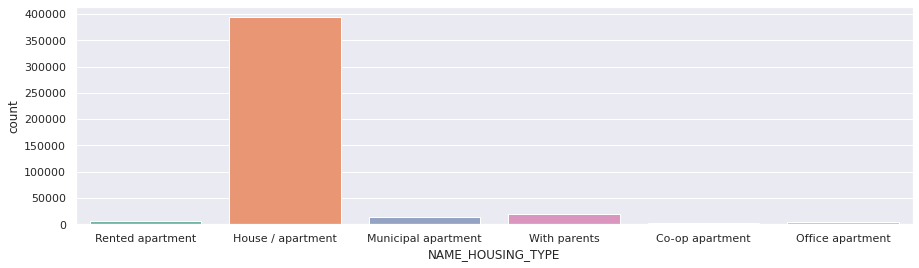

In [6]:
print("Types of house of the peoples :")
print(app['NAME_HOUSING_TYPE'].value_counts())
sns.set(rc = {'figure.figsize':(15,4)})
sns.countplot(x='NAME_HOUSING_TYPE', data=app, palette = 'Set2')

How many peoples own car :
N    275459
Y    163098
Name: FLAG_OWN_CAR, dtype: int64


<AxesSubplot:xlabel='FLAG_OWN_CAR', ylabel='count'>

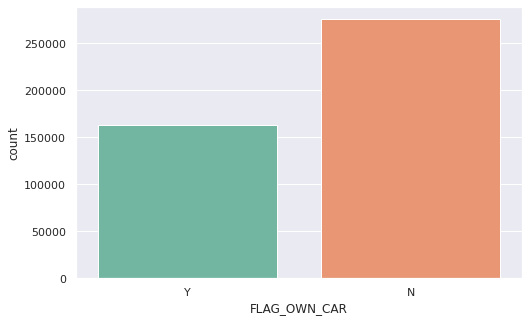

In [7]:
print("How many peoples own car :")
print(app['FLAG_OWN_CAR'].value_counts())
sns.set(rc = {'figure.figsize':(8,5)})
sns.countplot(x='FLAG_OWN_CAR', data=app, palette = 'Set2')

Income Types Of the Person :
Working                 226104
Commercial associate    100757
Pensioner                75493
State servant            36186
Student                     17
Name: NAME_INCOME_TYPE, dtype: int64


<AxesSubplot:xlabel='NAME_INCOME_TYPE', ylabel='count'>

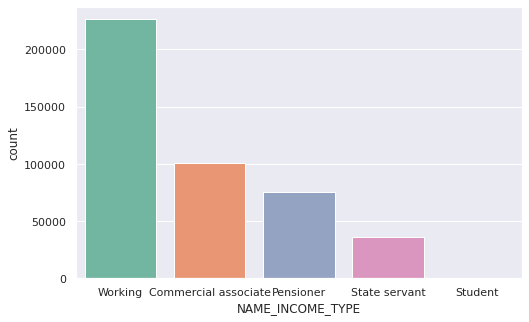

In [8]:
print("Income Types Of the Person :")
print(app['NAME_INCOME_TYPE'].value_counts())
sns.set(rc = {'figure.figsize':(8,5)})
sns.countplot(x='NAME_INCOME_TYPE', data=app, palette = 'Set2')

In [9]:
def unique_values():
    a = app.CODE_GENDER.unique()
    print("--------------CODE_GENDER--------------------------------------------")
    print(a)
    print()
    b = app.FLAG_OWN_CAR.unique()
    print("----------------------FLAG_OWN_CAR------------------------------------")
    print(b)
    print()
    c = app.FLAG_OWN_REALTY.unique()
    print('----------------------FLAG_OWN_REALTY--------------------------------------------')
    print(c)
    print()
    d = app.CNT_CHILDREN.unique()
    print('-------------------------CNT_CHILDREN-----------------------------------------')
    print(d)
    print()
    e = app.NAME_INCOME_TYPE.unique()
    print( '--------------------------NAME_INCOME_TYPE----------------------------------------')
    print(e)
    print()
    f = app.NAME_EDUCATION_TYPE.unique()
    print('--------------------------NAME_EDUCATION_TYPE----------------------------------------')
    print(f)
    print()
    g = app.NAME_FAMILY_STATUS.unique()
    print('--------------------------NAME_FAMILY_STATUS----------------------------------------')
    print(g)
    print()
    h = app.NAME_HOUSING_TYPE.unique()
    print('---------------------------NAME_HOUSING_TYPE---------------------------------------')
    print(h)
    print()
    i = app.OCCUPATION_TYPE.unique()
    print('------------------------OCCUPATION_TYPE------------------------------------------')
    print(i)
    print()
    j = app.CNT_FAM_MEMBERS.value_counts()
    print('----------------------------CNT_FAM_MEMBERS--------------------------------------')
    print(j)
    print()
    return unique_values

In [10]:
unique_values()

--------------CODE_GENDER--------------------------------------------
['M' 'F']

----------------------FLAG_OWN_CAR------------------------------------
['Y' 'N']

----------------------FLAG_OWN_REALTY--------------------------------------------
['Y' 'N']

-------------------------CNT_CHILDREN-----------------------------------------
[ 0  1  3  2  4  5 14 19  7  9 12  6]

--------------------------NAME_INCOME_TYPE----------------------------------------
['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']

--------------------------NAME_EDUCATION_TYPE----------------------------------------
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']

--------------------------NAME_FAMILY_STATUS----------------------------------------
['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']

---------------------------NAME_HOUSING_TYPE---------------------------------------
['Rented apartment' 'House / a

<function __main__.unique_values()>

In [11]:
app.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'],
      dtype='object')

In [12]:
# dropping duplicate rows
app.drop_duplicates(subset = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'], keep = 'first', inplace = True)

In [13]:
app.shape

(90085, 18)

In [14]:
app.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90085 entries, 0 to 438553
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   90085 non-null  int64  
 1   CODE_GENDER          90085 non-null  object 
 2   FLAG_OWN_CAR         90085 non-null  object 
 3   FLAG_OWN_REALTY      90085 non-null  object 
 4   CNT_CHILDREN         90085 non-null  int64  
 5   AMT_INCOME_TOTAL     90085 non-null  float64
 6   NAME_INCOME_TYPE     90085 non-null  object 
 7   NAME_EDUCATION_TYPE  90085 non-null  object 
 8   NAME_FAMILY_STATUS   90085 non-null  object 
 9   NAME_HOUSING_TYPE    90085 non-null  object 
 10  DAYS_BIRTH           90085 non-null  int64  
 11  DAYS_EMPLOYED        90085 non-null  int64  
 12  FLAG_MOBIL           90085 non-null  int64  
 13  FLAG_WORK_PHONE      90085 non-null  int64  
 14  FLAG_PHONE           90085 non-null  int64  
 15  FLAG_EMAIL           90085 non-null

In [15]:
credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [16]:
credit.shape

(1048575, 3)

In [17]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [18]:
# Data frame to analyze length of time since initial approval of credit card
# Shows number of past dues, paid off and no loan status.
grouped = credit.groupby('ID')

pivot_tb = credit.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
pivot_tb['open_month'] = grouped['MONTHS_BALANCE'].min()
pivot_tb['end_month'] = grouped['MONTHS_BALANCE'].max()
pivot_tb['window'] = pivot_tb['end_month'] - pivot_tb['open_month']
pivot_tb['window'] += 1 # Adding 1 since month starts at 0.

#Counting number of past dues, paid offs and no loans.
pivot_tb['paid_off'] = pivot_tb[pivot_tb.iloc[:,0:61] == 'C'].count(axis = 1)
pivot_tb['pastdue_1-29'] = pivot_tb[pivot_tb.iloc[:,0:61] == '0'].count(axis = 1)
pivot_tb['pastdue_30-59'] = pivot_tb[pivot_tb.iloc[:,0:61] == '1'].count(axis = 1)
pivot_tb['pastdue_60-89'] = pivot_tb[pivot_tb.iloc[:,0:61] == '2'].count(axis = 1)
pivot_tb['pastdue_90-119'] = pivot_tb[pivot_tb.iloc[:,0:61] == '3'].count(axis = 1)
pivot_tb['pastdue_120-149'] = pivot_tb[pivot_tb.iloc[:,0:61] == '4'].count(axis = 1)
pivot_tb['pastdue_over_150'] = pivot_tb[pivot_tb.iloc[:,0:61] == '5'].count(axis = 1)
pivot_tb['no_loan'] = pivot_tb[pivot_tb.iloc[:,0:61] == 'X'].count(axis = 1)
#Setting Id column to merge with app data.
pivot_tb['ID'] = pivot_tb.index

In [19]:
pivot_tb.head(10)

MONTHS_BALANCE,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,...,window,paid_off,pastdue_1-29,pastdue_30-59,pastdue_60-89,pastdue_90-119,pastdue_120-149,pastdue_over_150,no_loan,ID
ID,,,,,,,,,,,,,,,,,,,,,
5001711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,0,3,0,0,0,0,0,1,5001711
5001712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19,9,10,0,0,0,0,0,0,5001712
5001713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22,0,0,0,0,0,0,0,22,5001713
5001714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15,0,0,0,0,0,0,0,15,5001714
5001715,NaN,X,X,X,X,X,X,X,X,X,...,60,0,0,0,0,0,0,0,60,5001715
5001717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22,5,17,0,0,0,0,0,0,5001717
5001718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39,3,24,2,0,0,0,0,10,5001718
5001719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,43,41,2,0,0,0,0,0,0,5001719
5001720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36,0,29,7,0,0,0,0,0,5001720


## Data Cleaning

In [20]:
def data_cleansing(data):
    # Adding number of family members with number of children to get overall family members.
    data['CNT_FAM_MEMBERS'] = data['CNT_FAM_MEMBERS'] + data['CNT_CHILDREN']
    
    dropped_cols = ['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL','OCCUPATION_TYPE','CNT_CHILDREN']
    data = data.drop(dropped_cols, axis = 1)
    
    #converting birth years and days employed to years.
    data['DAYS_BIRTH'] = np.abs(data['DAYS_BIRTH']/365) #Absolute
    data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED']/365 
    
    #Cleaning up categorical values to lower the count of dummy variables.
    housing_type = {'House / apartment' : 'House / apartment',
                   'With parents': 'With parents',
                    'Municipal apartment' : 'House / apartment',
                    'Rented apartment': 'House / apartment',
                    'Office apartment': 'House / apartment',
                    'Co-op apartment': 'House / apartment'}
              
    income_type = {'Commercial associate':'Working',
                  'State servant':'Working',
                  'Working':'Working',
                  'Pensioner':'Pensioner',
                  'Student':'Student'}
    education_type = {'Secondary / secondary special':'secondary',
                     'Lower secondary':'secondary',
                     'Higher education':'Higher education',
                     'Incomplete higher':'Higher education',
                     'Academic degree':'Academic degree'}
    family_status = {'Single / not married':'Single',
                     'Separated':'Single',
                     'Widow':'Single',
                     'Civil marriage':'Married',
                    'Married':'Married'}
    data['NAME_HOUSING_TYPE'] = data['NAME_HOUSING_TYPE'].map(housing_type)
    data['NAME_INCOME_TYPE'] = data['NAME_INCOME_TYPE'].map(income_type)
    data['NAME_EDUCATION_TYPE']=data['NAME_EDUCATION_TYPE'].map(education_type)
    data['NAME_FAMILY_STATUS']=data['NAME_FAMILY_STATUS'].map(family_status)
    return data

In [21]:
cleansed_app = data_cleansing(app)

In [22]:
cleansed_app

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,427500.0,Working,Higher education,Married,House / apartment,32.890411,-12.443836,2.0
2,5008806,M,Y,Y,112500.0,Working,secondary,Married,House / apartment,58.832877,-3.106849,2.0
3,5008808,F,N,Y,270000.0,Working,secondary,Single,House / apartment,52.356164,-8.358904,1.0
7,5008812,F,N,Y,283500.0,Pensioner,Higher education,Single,House / apartment,61.545205,1000.665753,1.0
10,5008815,M,Y,Y,270000.0,Working,Higher education,Married,House / apartment,46.224658,-2.106849,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
438541,6837707,M,N,Y,202500.0,Working,Higher education,Married,House / apartment,37.013699,-6.326027,2.0
438545,6839651,F,N,Y,99000.0,Pensioner,secondary,Single,House / apartment,51.594521,1000.665753,4.0
438547,6839917,F,N,Y,180000.0,Pensioner,Higher education,Married,House / apartment,30.043836,-7.408219,2.0
438552,6840104,M,N,Y,135000.0,Pensioner,secondary,Single,House / apartment,62.238356,1000.665753,1.0


In [23]:
def unique_values():
    a = cleansed_app.CODE_GENDER.unique()
    print("--------------CODE_GENDER--------------------------------------------")
    print(a)
    print()
    b = cleansed_app.FLAG_OWN_CAR.unique()
    print("----------------------FLAG_OWN_CAR------------------------------------")
    print(b)
    print()
    c = cleansed_app.FLAG_OWN_REALTY.unique()
    print('----------------------FLAG_OWN_REALTY--------------------------------------------')
    print(c)
    print()
   
    e = cleansed_app.NAME_INCOME_TYPE.unique()
    print( '--------------------------NAME_INCOME_TYPE----------------------------------------')
    print(e)
    print()
    f = cleansed_app.NAME_EDUCATION_TYPE.unique()
    print('--------------------------NAME_EDUCATION_TYPE----------------------------------------')
    print(f)
    print()
    g = cleansed_app.NAME_FAMILY_STATUS.unique()
    print('--------------------------NAME_FAMILY_STATUS----------------------------------------')
    print(g)
    print()
    h = cleansed_app.NAME_HOUSING_TYPE.unique()
    print('---------------------------NAME_HOUSING_TYPE---------------------------------------')
    print(h)
    print()
    
    j = cleansed_app.CNT_FAM_MEMBERS.value_counts()
    print('----------------------------CNT_FAM_MEMBERS--------------------------------------')
    print(j)
    print()
    
    return unique_values

In [24]:
unique_values()

--------------CODE_GENDER--------------------------------------------
['M' 'F']

----------------------FLAG_OWN_CAR------------------------------------
['Y' 'N']

----------------------FLAG_OWN_REALTY--------------------------------------------
['Y' 'N']

--------------------------NAME_INCOME_TYPE----------------------------------------
['Working' 'Pensioner' 'Student']

--------------------------NAME_EDUCATION_TYPE----------------------------------------
['Higher education' 'secondary' 'Academic degree']

--------------------------NAME_FAMILY_STATUS----------------------------------------
['Married' 'Single']

---------------------------NAME_HOUSING_TYPE---------------------------------------
['House / apartment' 'With parents']

----------------------------CNT_FAM_MEMBERS--------------------------------------
2.0     44488
1.0     18292
4.0     15007
6.0      7411
3.0      3002
8.0      1038
5.0       628
10.0      105
7.0        72
12.0       24
9.0         9
14.0        2
16.0     

<function __main__.unique_values()>

## Feature Engineering
**A ratio based method was used to create the target variable. For example, given a client with a time period of 60 months, if the client had paid off loan 40 times and was late 20 times, this would be considered a fairly good client given that there were more loans that were paid off on time compared to late payments. If a client had no loans throughout the initial approval of the credit card account, by default, this would be considered a good client as well. To identify a bad client, the number of past dues would exceed the number of loans paid off or if the client only has past dues. It may be better to incorporate a set difference between number of paid off loans and number of past dues. Meaning, there needs to be a significant gap between paid off loans and past dues. If a person has 50 past dues and 51 paid off loans, based on the ratio method, this would be considered good. However the difference is only 1 and this may not be a good sign of a good client. For simplicity sake, I will not adjust the algorithm further and keep it at ratio decisioning. Code is also not optimal, adjustment may be needed for the code to compute faster.**

In [25]:
def feature_engineering_target(data):
    good_or_bad = []
    for index, row in data.iterrows():
        paid_off = row['paid_off']
        over_1 = row['pastdue_1-29']
        over_30 = row['pastdue_30-59']
        over_60 = row['pastdue_60-89'] 
        over_90 = row['pastdue_90-119']
        over_120 = row['pastdue_120-149'] + row['pastdue_over_150']
        no_loan = row['no_loan']
            
        overall_pastdues = over_1+over_30+over_60+over_90+over_120    
            
        if overall_pastdues == 0:
            if paid_off >= no_loan or paid_off <= no_loan:
                good_or_bad.append(1)
            elif paid_off == 0 and no_loan == 1:
                good_or_bad.append(1)
        
        elif overall_pastdues != 0:
            if paid_off > overall_pastdues:
                good_or_bad.append(1)
            elif paid_off <= overall_pastdues:
                good_or_bad.append(0)
        
        elif paid_off == 0 and no_loan != 0:
            if overall_pastdues <= no_loan or overall_pastdues >= no_loan:
                good_or_bad.append(0)

        else:
            good_or_bad.append(1)
                
        
    return good_or_bad

There is data on clients in the credit data that intersect with the application data. the following is a merge between the two data frames given on the data of clients that exist in both data sets. Featured engineered additional columns from the credit data.

In [26]:
target = pd.DataFrame()
target['ID'] = pivot_tb.index
target['paid_off'] = pivot_tb['paid_off'].values
target['#_of_pastdues'] = pivot_tb['pastdue_1-29'].values+ pivot_tb['pastdue_30-59'].values + pivot_tb['pastdue_60-89'].values +pivot_tb['pastdue_90-119'].values+pivot_tb['pastdue_120-149'].values +pivot_tb['pastdue_over_150'].values
target['no_loan'] = pivot_tb['no_loan'].values
target['target'] = feature_engineering_target(pivot_tb)
credit_app = cleansed_app.merge(target, how = 'inner', on = 'ID')
credit_app.drop('ID', axis = 1, inplace = True)

In [27]:
credit_app

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,paid_off,#_of_pastdues,no_loan,target
0,M,Y,Y,427500.0,Working,Higher education,Married,House / apartment,32.890411,-12.443836,2.0,13,2,1,1
1,M,Y,Y,112500.0,Working,secondary,Married,House / apartment,58.832877,-3.106849,2.0,7,7,16,0
2,F,N,Y,270000.0,Working,secondary,Single,House / apartment,52.356164,-8.358904,1.0,0,2,3,0
3,F,N,Y,283500.0,Pensioner,Higher education,Single,House / apartment,61.545205,1000.665753,1.0,0,14,3,0
4,M,Y,Y,270000.0,Working,Higher education,Married,House / apartment,46.224658,-2.106849,2.0,0,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9704,F,N,N,180000.0,Pensioner,secondary,Married,House / apartment,56.438356,-0.542466,2.0,0,21,0,0
9705,F,N,Y,112500.0,Working,secondary,Married,House / apartment,43.389041,-7.380822,2.0,8,12,0,0
9706,M,Y,Y,90000.0,Working,secondary,Married,House / apartment,52.331507,-4.715068,2.0,0,17,5,0
9707,F,N,Y,157500.0,Pensioner,Higher education,Married,House / apartment,33.936986,-3.630137,2.0,14,19,0,0


In [28]:
from sklearn.preprocessing import LabelEncoder

cg = LabelEncoder()
oc = LabelEncoder()
own_r = LabelEncoder()
it = LabelEncoder()
et = LabelEncoder()
fs = LabelEncoder()
ht = LabelEncoder()


credit_app['CODE_GENDER'] = cg.fit_transform(credit_app['CODE_GENDER'])
credit_app['FLAG_OWN_CAR'] = oc.fit_transform(credit_app['FLAG_OWN_CAR'])
credit_app['FLAG_OWN_REALTY'] = own_r.fit_transform(credit_app['FLAG_OWN_REALTY'])
credit_app['NAME_INCOME_TYPE'] = it.fit_transform(credit_app['NAME_INCOME_TYPE'])
credit_app['NAME_EDUCATION_TYPE'] = et.fit_transform(credit_app['NAME_EDUCATION_TYPE'])
credit_app['NAME_FAMILY_STATUS'] = fs.fit_transform(credit_app['NAME_FAMILY_STATUS'])
credit_app['NAME_HOUSING_TYPE'] = ht.fit_transform(credit_app['NAME_HOUSING_TYPE'])
    
    

In [29]:
print("CODE_GENDER",credit_app['CODE_GENDER'].unique())
print(cg.inverse_transform(list(credit_app['CODE_GENDER'].unique())))
print()
print("FLAG_OWN_CAR:",credit_app['FLAG_OWN_CAR'].unique())
print(oc.inverse_transform(list(credit_app['FLAG_OWN_CAR'].unique())))
print()
print("FLAG_OWN_REALTY", credit_app['FLAG_OWN_REALTY'].unique())
print(own_r.inverse_transform(list(credit_app['FLAG_OWN_REALTY'].unique())))
print()
print("NAME_INCOME_TYPE",credit_app['NAME_INCOME_TYPE'].unique())
print(it.inverse_transform(list(credit_app['NAME_INCOME_TYPE'].unique())))
print()
print("NAME_EDUCATION_TYPE",credit_app['NAME_EDUCATION_TYPE'].unique())
print(et.inverse_transform(list(credit_app['NAME_EDUCATION_TYPE'].unique())))
print()
print("NAME_FAMILY_STATUS",credit_app['NAME_FAMILY_STATUS'].unique())
print(fs.inverse_transform(list(credit_app['NAME_FAMILY_STATUS'].unique())))
print()
print("NAME_HOUSING_TYPE",credit_app['NAME_HOUSING_TYPE'].unique())
print(ht.inverse_transform(list(credit_app['NAME_HOUSING_TYPE'].unique())))

CODE_GENDER [1 0]
['M' 'F']

FLAG_OWN_CAR: [1 0]
['Y' 'N']

FLAG_OWN_REALTY [1 0]
['Y' 'N']

NAME_INCOME_TYPE [2 0 1]
['Working' 'Pensioner' 'Student']

NAME_EDUCATION_TYPE [1 2 0]
['Higher education' 'secondary' 'Academic degree']

NAME_FAMILY_STATUS [0 1]
['Married' 'Single']

NAME_HOUSING_TYPE [0 1]
['House / apartment' 'With parents']


In [30]:
credit_app

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,paid_off,#_of_pastdues,no_loan,target
0,1,1,1,427500.0,2,1,0,0,32.890411,-12.443836,2.0,13,2,1,1
1,1,1,1,112500.0,2,2,0,0,58.832877,-3.106849,2.0,7,7,16,0
2,0,0,1,270000.0,2,2,1,0,52.356164,-8.358904,1.0,0,2,3,0
3,0,0,1,283500.0,0,1,1,0,61.545205,1000.665753,1.0,0,14,3,0
4,1,1,1,270000.0,2,1,0,0,46.224658,-2.106849,2.0,0,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9704,0,0,0,180000.0,0,2,0,0,56.438356,-0.542466,2.0,0,21,0,0
9705,0,0,1,112500.0,2,2,0,0,43.389041,-7.380822,2.0,8,12,0,0
9706,1,1,1,90000.0,2,2,0,0,52.331507,-4.715068,2.0,0,17,5,0
9707,0,0,1,157500.0,0,1,0,0,33.936986,-3.630137,2.0,14,19,0,0


In [31]:
x = credit_app[credit_app.drop('target', axis = 1).columns]
y = credit_app['target']
xtrain, xtest, ytrain, ytest = train_test_split(x,y, train_size = 0.8, random_state = 0)

In [32]:
xtest

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,paid_off,#_of_pastdues,no_loan
6152,0,0,1,270000.0,2,1,1,0,29.334247,-2.095890,1.0,0,6,0
3411,0,0,1,180000.0,2,2,1,0,29.424658,-3.556164,3.0,0,12,2
272,0,1,1,225000.0,2,1,0,0,38.761644,-4.358904,4.0,0,13,0
7051,0,0,1,202500.0,2,1,1,0,42.734247,-21.331507,1.0,0,12,46
3318,0,0,0,270000.0,2,1,0,0,40.967123,-22.216438,2.0,0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6046,0,0,1,135000.0,0,2,1,0,66.408219,1000.665753,1.0,0,21,11
7624,0,1,1,450000.0,0,1,1,0,60.501370,1000.665753,1.0,0,6,1
5740,0,0,1,202500.0,2,2,0,0,48.117808,-4.693151,2.0,6,9,0
842,0,1,1,216000.0,2,1,0,0,41.846575,-3.898630,2.0,11,18,0


In [33]:
xtrain

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,paid_off,#_of_pastdues,no_loan
8235,0,1,0,58500.0,0,2,0,0,64.046575,1000.665753,2.0,18,10,0
1755,1,1,1,270000.0,2,2,0,0,42.430137,-8.473973,2.0,0,12,1
509,0,1,1,157500.0,2,2,0,0,41.153425,-18.846575,6.0,0,40,6
5923,0,1,0,90000.0,2,2,0,0,41.586301,-2.715068,4.0,0,12,1
7722,0,0,1,90000.0,0,2,0,0,60.890411,1000.665753,2.0,4,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7891,0,0,1,76500.0,0,2,1,0,58.704110,1000.665753,1.0,20,34,5
9225,1,1,1,180000.0,2,2,1,0,52.383562,-5.268493,1.0,0,2,0
4859,1,0,1,135000.0,2,2,0,0,43.320548,-22.167123,4.0,0,2,0
3264,1,1,0,112500.0,2,2,0,0,27.408219,-5.375342,2.0,0,4,1


In [34]:
ytrain

8235    1
1755    0
509     0
5923    0
7722    0
       ..
7891    0
9225    0
4859    0
3264    0
2732    0
Name: target, Length: 7767, dtype: int64

In [35]:
print(ytrain.value_counts())
print(ytest.value_counts())

0    4258
1    3509
Name: target, dtype: int64
0    1037
1     905
Name: target, dtype: int64


Imported SMOTE in case of high imbalance of target variable. However, it does not seem to be highly imbalanced so it is fine not to use an imbalanced technique.

# Random Forest

It is working with the principal of BAGING, means it is taking samples from the dataset not taking all data at a time so it is able to handle imbalanced data

In [36]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 2)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

grid_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
grid = RandomizedSearchCV(rf, grid_rf, cv = 5,verbose = True, n_jobs = -1)
grid.fit(xtrain,ytrain)
params = grid.best_params_
print(params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.7s finished


{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}


In [37]:
rf_grid = RandomForestClassifier(n_estimators = 200, min_samples_split = 5, min_samples_leaf = 2, max_features = 'sqrt',
                                 max_depth = 80, bootstrap = True, random_state = 0)
rf.fit(xtrain, ytrain)
predictions_test = rf.predict(xtest)
roc_auc_test = roc_auc_score(ytest,predictions_test)
accuracy_test = accuracy_score(ytest,predictions_test)
f1_test = f1_score(ytest, predictions_test)

print('roc_auc test: ', roc_auc_test)
print('accuracy test: ', accuracy_test)
print('f1 test: ', f1_test)

roc_auc test:  0.9892417033836448
accuracy test:  0.9891864057672503
f1 test:  0.9884169884169883


In [38]:
y_predict=rf.predict(xtest)
#y_predict_train=forest.predict(X_train)

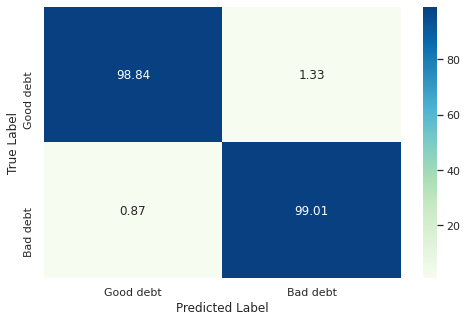

In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['Good debt', 'Bad debt']
C = confusion_matrix(ytest,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C,annot=True, fmt=".2f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [40]:
predictions_test = rf.predict([[1,1,1,112500.0,2,2,0,0,58.832877,-3.106849,2.0,7,7,16]])

In [41]:
predictions_test

array([0])

In [42]:
import pickle
pickle.dump(rf,open("c_card_aproval_pred.pickle","wb"))

In [43]:
!pip install -U ibm-watson-machine-learning

In [44]:
from ibm_watson_machine_learning import APIClient
import json
import numpy as np

In [45]:
wml_credentials = {
    "apikey":"5LTSIhnTIu25ecqNupdDLYO_U4AIBS8jTHfttjKe-Ekt",
    "url":"https://us-south.ml.cloud.ibm.com"
}

In [46]:
wml_client = APIClient(wml_credentials)
wml_client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  ------------------------------  ------------------------
ID                                    NAME                            CREATED
bd4db94f-947b-4203-86d5-3d044a6d25fb  Credit_card_approval_detection  2021-12-13T09:21:58.292Z
c69a7f8c-d160-4207-bcdf-17154d40766e  risk                            2021-11-26T05:13:31.073Z
0c4cbc44-cb18-42bd-ba83-fc3656d60b93  iceburg_deployment              2021-11-19T12:54:57.915Z
044db268-574f-4787-81ba-eaa7b243e439  F_s_deployment                  2021-11-17T07:03:36.948Z
e25a99a4-a8bd-40ad-90e5-0c40b5f79a5f  deployment_brain_t              2021-11-17T05:45:48.404Z
------------------------------------  ------------------------------  ------------------------


In [47]:
SPACE_ID="bd4db94f-947b-4203-86d5-3d044a6d25fb"

In [48]:
wml_client.set.default_space(SPACE_ID)

'SUCCESS'

In [49]:
wml_client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
scikit-learn_0.22-py3.6        154010fa-5b3b-4ac1-82af-4d5ee5abbc85  base
default_r3.6                   1b70aec3-ab34-4b87-8aa0-a4a3c8296a36  base
pytorch-onnx_1.3-py3.6         1bc6029

In [50]:
import sklearn
sklearn.__version__

'0.23.2'

In [51]:
MODEL_NAME = 'credit_card_approval'
DEPLOYMENT_NAME = 'Credit_card_approval_detection'
Cred_MODEL = rf

In [52]:
# Set Python Version
software_spec_uid = wml_client.software_specifications.get_id_by_name('default_py3.8')

# Setup model meta
model_props = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME, 
    wml_client.repository.ModelMetaNames.TYPE: 'scikit-learn_0.23', 
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid 
}

In [54]:
#Save model
model_details = wml_client.repository.store_model(
    model=Cred_MODEL, 
    meta_props=model_props, 
    training_data=xtrain, 
    training_target=ytrain
)

In [55]:
print(model_details)

{'entity': {'label_column': 'target', 'software_spec': {'id': 'ab9e1b80-f2ce-592c-a7d2-4f2344f77194', 'name': 'default_py3.8'}, 'training_data_references': [{'connection': {'access_key_id': 'not_applicable', 'endpoint_url': 'not_applicable', 'secret_access_key': 'not_applicable'}, 'id': '1', 'location': {}, 'schema': {'fields': [{'name': 'CODE_GENDER', 'type': 'int64'}, {'name': 'FLAG_OWN_CAR', 'type': 'int64'}, {'name': 'FLAG_OWN_REALTY', 'type': 'int64'}, {'name': 'AMT_INCOME_TOTAL', 'type': 'float64'}, {'name': 'NAME_INCOME_TYPE', 'type': 'int64'}, {'name': 'NAME_EDUCATION_TYPE', 'type': 'int64'}, {'name': 'NAME_FAMILY_STATUS', 'type': 'int64'}, {'name': 'NAME_HOUSING_TYPE', 'type': 'int64'}, {'name': 'DAYS_BIRTH', 'type': 'float64'}, {'name': 'DAYS_EMPLOYED', 'type': 'float64'}, {'name': 'CNT_FAM_MEMBERS', 'type': 'float64'}, {'name': 'paid_off', 'type': 'int64'}, {'name': '#_of_pastdues', 'type': 'int64'}, {'name': 'no_loan', 'type': 'int64'}], 'id': '1', 'type': 'DataFrame'}, 'ty

In [ ]:
test_model = rf.predict([[1,1,1,112500.0,2,2,0,0,58.832877,-3.106849,2.0,7,7,16]])
test_model